# Fine-tune TrOCR on the Bentham Handwriting Database

In this notebook, we are going to fine-tune a pre-trained TrOCR model on the Bentham Handwriting Database, a collection of annotated images of  handwritten text.


## Set-up environment

First, let's install the required libraries:
- Transformers (for the TrOCR model)
- Datasets & Jiwer (for the evaluation metric)

In [2]:
!pip install -q transformers

In [3]:
!pip install -q datasets jiwer

## Prepare Bentham data

We'll load the Bentham dataset that has been converted to IAM format using our conversion script.
The dataset should have the following structure:
```
bentham_iam_format/
├── images/           # Line images
├── gt.txt           # Ground truth file (main)
├── gt_train.txt     # Training split
└── gt_val.txt       # Validation split
```

In [ ]:
cd /content/drive/MyDrive/My progenAI

/content/drive/MyDrive/My progenAI


In [ ]:
pwd

'/content/drive/MyDrive/My progenAI'

In [ ]:
!mkdir dataset

mkdir: cannot create directory ‘dataset’: File exists


In [ ]:
!unzip -q bentham_iam_format.zip -d dataset/

In [4]:
import os
import pandas as pd
from PIL import Image

def load_iam_format_dataset(dataset_dir, split='train'):
    """
    Load IAM format dataset (works with original IAM or converted Bentham)

    Args:
        dataset_dir: Path to dataset directory containing images/ and gt files
        split: 'train', 'val', or 'all'
    """

    images_dir = os.path.join(dataset_dir, 'images')

    # Choose the appropriate ground truth file
    if split == 'train':
        gt_file = os.path.join(dataset_dir, 'gt_train.txt')
    elif split == 'val':
        gt_file = os.path.join(dataset_dir, 'gt_val.txt')
    else:  # 'all' or fallback
        gt_file = os.path.join(dataset_dir, 'gt.txt')

    # Fallback to main gt.txt if split files don't exist
    if not os.path.exists(gt_file):
        gt_file = os.path.join(dataset_dir, 'gt.txt')
        print(f"Using fallback gt.txt for {split} split")

    data = []

    with open(gt_file, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                # Split at first space: image_id text
                parts = line.split(' ', 1)
                if len(parts) == 2:
                    image_id, text = parts

                    # Find image file (try different extensions)
                    image_path = None
                    for ext in ['.png', '.jpg', '.jpeg', '.tiff', '.bmp']:
                        potential_path = os.path.join(images_dir, f"{image_id}{ext}")
                        if os.path.exists(potential_path):
                            image_path = potential_path
                            break

                    if image_path:
                        data.append({
                            'image_id': image_id,
                            'file_name': f"{image_id}{os.path.splitext(image_path)[1]}",
                            'text': text,
                            'image_path': image_path
                        })
                    else:
                        print(f"Warning: Image not found for {image_id}")

    return pd.DataFrame(data)

In [5]:
!pwd


'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
cd /content/drive/MyDrive/My progenAI/dataset/

/content/drive/MyDrive/My progenAI/dataset


In [8]:
# Set path to your converted Bentham dataset
DATASET_PATH = 'Dataset\\bentham_iam_format'  # Update this path to your dataset

# Load training and validation datasets
train_df = load_iam_format_dataset(DATASET_PATH, split='train')
test_df = load_iam_format_dataset(DATASET_PATH, split='val')

print(f"Loaded {len(train_df)} training samples")
print(f"Loaded {len(test_df)} validation samples")

# Show sample data
print("\nSample training data:")
print(train_df.head())

Loaded 18356 training samples
Loaded 4590 validation samples

Sample training data:
         image_id           file_name  \
0  bentham_019702  bentham_019702.png   
1  bentham_016498  bentham_016498.png   
2  bentham_013987  bentham_013987.png   
3  bentham_016775  bentham_016775.png   
4  bentham_017994  bentham_017994.png   

                                                text  \
0  therefore it is further agreed that in pursuan...   
1                                        comparative   
2                                                 29   
3             +  v . Hale ' s Hist . P.C le Common .   
4  guilty , and from which none but the guilty ev...   

                                          image_path  
0  Dataset\bentham_iam_format\images\bentham_0197...  
1  Dataset\bentham_iam_format\images\bentham_0164...  
2  Dataset\bentham_iam_format\images\bentham_0139...  
3  Dataset\bentham_iam_format\images\bentham_0167...  
4  Dataset\bentham_iam_format\images\bentham_0179...  


In [9]:
# Reset indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(f"Final dataset sizes:")
print(f"Training: {len(train_df)} samples")
print(f"Validation: {len(test_df)} samples")

Final dataset sizes:
Training: 18356 samples
Validation: 4590 samples


## Create PyTorch Dataset

We create a PyTorch dataset compatible with TrOCR. Each element should return:
- `pixel_values`: processed images for the model
- `labels`: tokenized text labels

We use `TrOCRProcessor` to prepare the data, which combines a `ViTFeatureExtractor` (for images) and a `RobertaTokenizer` (for text).

In [10]:
import torch
from torch.utils.data import Dataset
from PIL import Image



class BenthamDataset(Dataset):
    def __init__(self, df, processor, max_target_length=128):
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path and text
        image_path = self.df.loc[idx, 'image_path']
        text = self.df.loc[idx, 'text']

        # Load and process image (resize + normalize)
        image = Image.open(image_path).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        # Process text (tokenize)
        labels = self.processor.tokenizer(text,
                                        padding="max_length",
                                        max_length=self.max_target_length,
                                        truncation=True,
                                        return_tensors="pt").input_ids

        # Important: make sure PAD tokens are ignored by loss function
        labels[labels == self.processor.tokenizer.pad_token_id] = -100

        return {
            "pixel_values": pixel_values.squeeze(),
            "labels": labels.squeeze()
        }

In [ ]:
from transformers import TrOCRProcessor

# Initialize processor
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

# Create datasets
train_dataset = BenthamDataset(df=train_df, processor=processor)
eval_dataset = BenthamDataset(df=test_df, processor=processor)

print(f"Created training dataset with {len(train_dataset)} samples")
print(f"Created validation dataset with {len(eval_dataset)} samples")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

NameError: name 'train_df' is not defined

In [ ]:
# Verify dataset structure
encoding = train_dataset[0]
for k, v in encoding.items():
    print(k, v.shape)

# Decode labels to verify
labels = encoding['labels'].clone()
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(f"Sample text: {label_str}")

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])
Sample text: therefore it is further agreed that in pursuance of the said


Sample image size: (1606, 136)


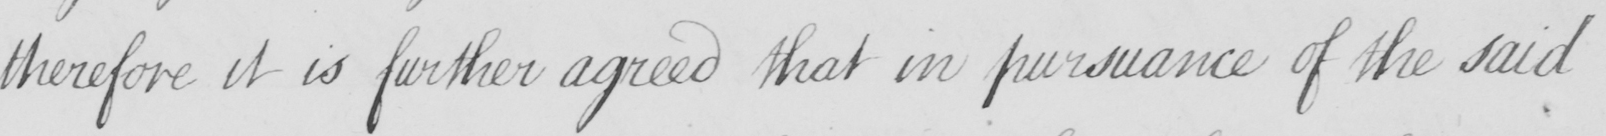

In [ ]:
# Show sample image
sample_image_path = train_df.loc[0, 'image_path']
sample_image = Image.open(sample_image_path).convert("RGB")
print(f"Sample image size: {sample_image.size}")
sample_image

## Create Data Loaders

In [ ]:
from torch.utils.data import DataLoader

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4, shuffle=False)

print(f"Training batches: {len(train_dataloader)}")
print(f"Validation batches: {len(eval_dataloader)}")

Training batches: 4589
Validation batches: 1148


## Initialize and Configure TrOCR Model

We initialize the TrOCR model from pretrained weights and configure it for fine-tuning on Bentham dataset.

In [ ]:
from transformers import VisionEncoderDecoderModel
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
model.to(device)

Using device: cuda


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (i

In [ ]:
# Configure model for training
# Set special tokens used for creating decoder_input_ids from labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

# Set correct vocab size
model.config.vocab_size = model.config.decoder.vocab_size

# Set beam search parameters for generation
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

print("Model configured for Bentham dataset fine-tuning")

Model configured for Bentham dataset fine-tuning


## Setup Evaluation Metric

We'll use Character Error Rate (CER) to evaluate model performance.

In [ ]:
!pip -q install evaluate

In [ ]:
import evaluate

cer_metric = evaluate.load("cer")

In [ ]:
def compute_cer(pred_ids, label_ids):
    """Compute Character Error Rate"""
    # Decode predictions
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)

    # Decode labels (replace -100 with pad token)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    # Compute CER
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    return cer

## Training Loop

Now we train the model on the Bentham dataset. The model will learn to recognize historical handwritten text.

In [ ]:
#from transformers import AdamW
from torch.optim import AdamW
from tqdm.notebook import tqdm

# Setup optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training parameters
num_epochs = 3

print(f"Starting training for {num_epochs} epochs...")
print(f"Training on {len(train_dataset)} samples")
print(f"Validating on {len(eval_dataset)} samples")
print(f"Using device: {device}")

Starting training for 3 epochs...
Training on 18356 samples
Validating on 4590 samples
Using device: cuda


In [ ]:
# Training loop
for epoch in range(num_epochs):
    print(f"\n=== Epoch {epoch + 1}/{num_epochs} ===")

    # Training phase
    model.train()
    train_loss = 0.0

    print("Training...")
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1} Training"):
        # Move batch to device
        for k, v in batch.items():
            batch[k] = v.to(device)

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    valid_cer = 0.0

    print("Validating...")
    with torch.no_grad():
        for batch in tqdm(eval_dataloader, desc=f"Epoch {epoch + 1} Validation"):
            # Move images to device
            pixel_values = batch["pixel_values"].to(device)

            # Generate predictions
            outputs = model.generate(pixel_values)

            # Compute CER
            cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
            valid_cer += cer

    avg_valid_cer = valid_cer / len(eval_dataloader)
    print(f"Validation CER: {avg_valid_cer:.4f}")

    # Save model checkpoint
    checkpoint_dir = f"bentham-trocr-epoch-{epoch + 1}"
    model.save_pretrained(checkpoint_dir)
    processor.save_pretrained(checkpoint_dir)
    print(f"Model saved to {checkpoint_dir}")

print("\n Training completed!")

# Save final model
final_model_dir = "bentham-trocr-final"
model.save_pretrained(final_model_dir)
processor.save_pretrained(final_model_dir)
print(f"Final model saved to {final_model_dir}")


=== Epoch 1/3 ===
Training...


Epoch 1 Training:   0%|          | 0/4589 [00:00<?, ?it/s]

## Test the Trained Model

Let's test our fine-tuned model on some validation samples to see how well it performs on Bentham historical handwriting.

In [ ]:
# Test on a few validation samples
model.eval()

# Get first few validation samples
test_indices = [0, 1, 2, 3, 4]

for idx in test_indices:
    # Get sample
    sample = eval_dataset[idx]
    image_path = test_df.loc[idx, 'image_path']
    ground_truth = test_df.loc[idx, 'text']

    # Generate prediction
    pixel_values = sample["pixel_values"].unsqueeze(0).to(device)

    with torch.no_grad():
        generated_ids = model.generate(pixel_values)
        predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Display results
    print(f"\n--- Sample {idx + 1} ---")
    print(f"Ground truth: {ground_truth}")
    print(f"Predicted:    {predicted_text}")

    # Load and display image
    image = Image.open(image_path)
    display(image)

## Model Performance Summary

Let's compute overall performance metrics on the validation set.

In [ ]:
# Compute overall validation CER
model.eval()
total_cer = 0.0
num_batches = 0

print("Computing final validation metrics...")

with torch.no_grad():
    for batch in tqdm(eval_dataloader, desc="Final validation"):
        # Generate predictions
        pixel_values = batch["pixel_values"].to(device)
        outputs = model.generate(pixel_values)

        # Compute CER
        cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
        total_cer += cer
        num_batches += 1

final_cer = total_cer / num_batches
print(f"\n Final Results:")
print(f"Final Validation CER: {final_cer:.4f}")
print(f"Character Accuracy: {(1 - final_cer) * 100:.2f}%")

print(f"\n Model Performance Summary:")
print(f"- Trained on {len(train_dataset)} Bentham historical handwriting samples")
print(f"- Validated on {len(eval_dataset)} samples")
print(f"- Final Character Error Rate: {final_cer:.4f}")
print(f"- Model saved to: bentham-trocr-final/")

## Using the Trained Model

Here's how to load and use your trained model for inference on new Bentham handwriting images:

In [ ]:
# Example: Load the trained model for inference
from transformers import VisionEncoderDecoderModel, TrOCRProcessor
from PIL import Image

def load_trained_model(model_path):
    """Load the fine-tuned model for inference"""
    model = VisionEncoderDecoderModel.from_pretrained(model_path)
    processor = TrOCRProcessor.from_pretrained(model_path)
    return model, processor

def predict_text(image_path, model, processor, device):
    """Predict text from handwriting image"""
    # Load and process image
    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

    # Generate prediction
    model.eval()
    with torch.no_grad():
        generated_ids = model.generate(pixel_values)
        predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return predicted_text

# Example usage:
# trained_model, trained_processor = load_trained_model("bentham-trocr-final")
# prediction = predict_text("path/to/handwriting/image.jpg", trained_model, trained_processor, device)
# print(f"Predicted text: {prediction}")